In [1]:
import os
import sys

import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
from typing import List
from pathlib import Path
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sys.path.append('..')
from importlib import reload
from beergenrnn import beerxml, dataset, model

In [25]:
reload(dataset)
ds = dataset.RecipeDataset(
#     path='../data/brewersfriend/'
)
dl = DataLoader(ds, batch_size=16, shuffle=True)

Load existing dicts from ..\data\brewdog\dicts.json


In [5]:
{k: len(v) for k, v in ds.dicts.items()}

{'hops_name': 1342,
 'hops_use': 8,
 'fermentables_name': 2276,
 'yeasts_name': 1010,
 'style_name': 181,
 'style_category': 58}

In [347]:
{k: len(v) for k, v in ds.dicts.items()}

{'hops_name': 61,
 'hops_use': 6,
 'fermentables_name': 56,
 'yeasts_name': 24,
 'style_name': 58,
 'style_category': 58}

In [32]:
reload(model)
mdl = model.RecipeModel(n_fermentables=len(ds.dicts['fermentables_name']),
                        n_hops=len(ds.dicts['hops_name']),
                        n_hops_uses=len(ds.dicts['hops_use']),
                        n_yeasts=len(ds.dicts['yeasts_name']),
                        n_styles=len(ds.dicts['style_name'])+3)
trainer = model.Trainer(mdl, name='brewdog', device='cuda')
mdl

RecipeModel(
  (style_model): Sequential(
    (0): Embedding(61, 32)
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): Tanh()
  )
  (fermentables_model): Model(
    (emb): Embedding(56, 32, padding_idx=0)
    (rnn): LSTM(32, 128, batch_first=True)
    (heads): Heads(
      (fcs): ModuleList(
        (0): Sequential(
          (0): Dropout(p=0.5, inplace=False)
          (1): Linear(in_features=128, out_features=56, bias=True)
        )
        (1): Sequential(
          (0): Dropout(p=0.5, inplace=False)
          (1): Linear(in_features=128, out_features=1, bias=True)
        )
      )
    )
  )
  (hops_model): Model(
    (emb): Embedding(61, 32, padding_idx=0)
    (rnn): LSTM(32, 128, batch_first=True)
    (heads): Heads(
      (fcs): ModuleList(
        (0): Sequential(
          (0): Dropout(p=0.5, inplace=False)
          (1): Linear(in_features=128, out_features=61, bias=True)
        )
        (1): Sequential(
          (0): Dropout(p=0.5, inplace=False)
    

In [33]:
loss = trainer.fit(300, dl)

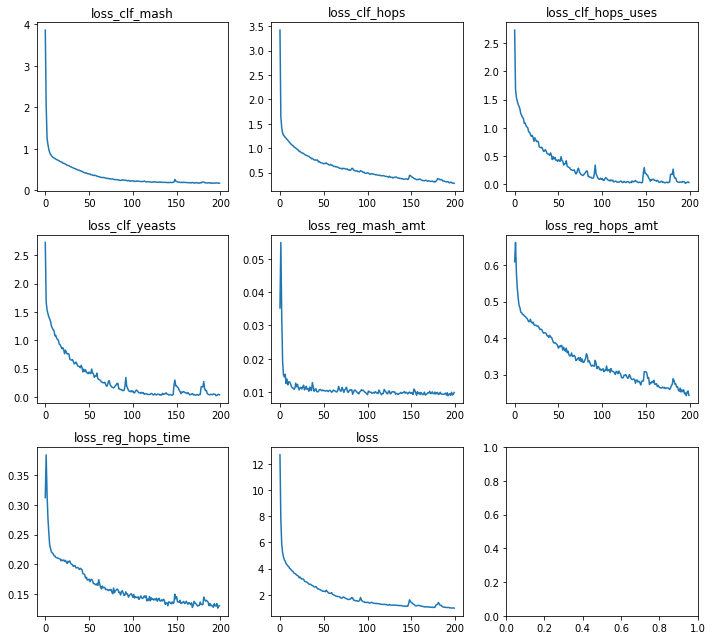

In [270]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(10,9))
for (loss_name, history), ax in zip(loss.items(), axes.flat):
    ax.plot(np.arange(len(history)), history)
    ax.set_title(loss_name)

plt.tight_layout()
plt.show()

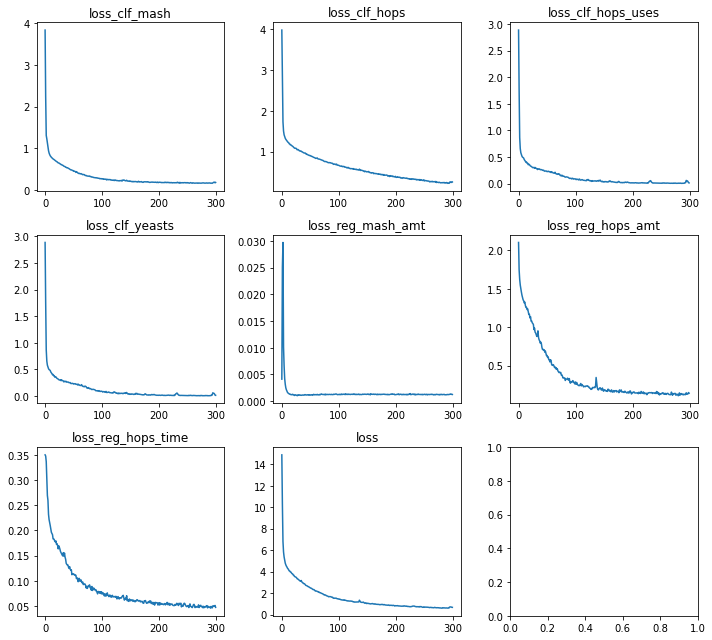

In [34]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(10,9))
for (loss_name, history), ax in zip(loss.items(), axes.flat):
    ax.plot(np.arange(len(history)), history)
    ax.set_title(loss_name)

plt.tight_layout()
plt.show()

In [22]:
mdl.load_state_dict(torch.load('../checkpoints/bf.pth'))

<All keys matched successfully>

In [29]:
def decode_predictions(generated, dicts, style, batch_size=20):
    reversed_dicts = {n: {v: k for k, v in d.items()} for n, d in dicts.items()}
    print(f'Generate style {reversed_dicts["style_name"][style] if style is not None else "unknown"}, batch size {batch_size} liters')
    generated = {k: [reversed_dicts[k][i] for i in v] if k in reversed_dicts else list(v) for k, v in generated.items()}
    
    generated['hops_amount'] = [round(v * batch_size) for v in generated['hops_amount']]
    generated['fermentables_amount'] = [round(v * batch_size, 2) for v in generated['fermentables_amount']]
    generated['hops_time'] = [int(v * 60) for v in generated['hops_time']]
    return generated

In [30]:
ds.dicts['style_name']

{'altbier': 3,
 'american ale': 4,
 'american amber ale': 5,
 'barley wine': 6,
 'belgian ale': 7,
 'belgian blonde': 8,
 'belgian strong ale': 9,
 'berliner weisse': 10,
 'bitter': 11,
 'black barley wine': 12,
 'black ipa': 13,
 'black lager': 14,
 'blonde imperial stout': 15,
 'braggot': 16,
 'breakfast stout': 17,
 'brown ale': 18,
 'cask ale': 19,
 'double ipa': 20,
 'eisbock': 21,
 'fruit beer': 22,
 'german hefeweizen': 23,
 'gose': 24,
 'imperial ale': 25,
 'imperial black ipa': 26,
 'imperial brown ale': 27,
 'imperial ipa': 28,
 'imperial pilsner': 29,
 'imperial porter': 30,
 'imperial red ale': 31,
 'imperial smoked porter': 32,
 'imperial stout': 33,
 'imperial weizenbock': 34,
 'imperial wheat': 35,
 'international pale lager': 36,
 'ipa': 37,
 'irish stout': 38,
 'kãlsch': 39,
 'lager': 40,
 'low alcohol': 41,
 'milk stout': 42,
 'pale ale': 43,
 'pilsner': 44,
 'porter': 45,
 'quadrupel': 46,
 'quadruple ipa': 47,
 'red ale': 48,
 'rye ale': 49,
 'rye ipa': 50,
 'rye pa

In [36]:
style = 25
generated = mdl.generate(style, deterministic=True, device='cuda')
decode_predictions(generated, ds.dicts, style)

Generate style imperial ale, batch size 20 liters


{'fermentables_name': ['extra pale', 'chocolate', 'carafa special type 3'],
 'fermentables_amount': [5.61, 0.91, 0.0],
 'hops_name': ['saaz'],
 'hops_amount': [46],
 'hops_time': [11],
 'hops_use': ['boil'],
 'yeasts_name': ['wyeast 3522 belgian ardennes',
  'wyeast 3522 belgian ardennes',
  'wyeast 3522 belgian ardennes',
  'wyeast 3522 belgian ardennes',
  'wyeast 3522 belgian ardennes',
  'wyeast 3522 belgian ardennes',
  'wyeast 3522 belgian ardennes',
  'wyeast 3522 belgian ardennes',
  'wyeast 3522 belgian ardennes',
  'wyeast 3522 belgian ardennes',
  'wyeast 3522 belgian ardennes',
  'wyeast 3522 belgian ardennes',
  'wyeast 3522 belgian ardennes',
  'wyeast 3522 belgian ardennes',
  'wyeast 3522 belgian ardennes',
  'wyeast 3522 belgian ardennes']}

In [42]:
style = 6
generated = mdl.generate(style, deterministic=True, device='cuda')
decode_predictions(generated, ds.dicts, style)

Generate style barley wine, batch size 20 liters


{'fermentables_name': ['extra pale', 'caramalt', 'dark crystal', 'munich'],
 'fermentables_amount': [5.68, 0.77, 0.35, 0.49],
 'hops_name': [],
 'hops_amount': [],
 'hops_time': [],
 'hops_use': [],
 'yeasts_name': ['<start>']}

Style embeddings

In [161]:
style_emb = mdl.style_model[0].weight.detach().numpy()
style_emb.shape

(128, 32)

In [167]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [181]:
man = TSNE(n_components=2, perplexity=4)
pc = man.fit_transform(style_emb[3:61])
pc.shape

(58, 2)

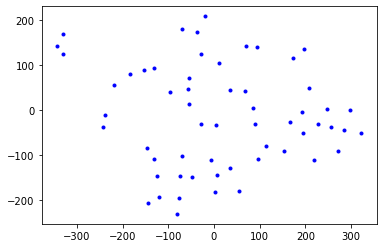

In [182]:
plt.plot(pc[:,0], pc[:,1], 'b.')